Saving Teddy.png to Teddy (2).png


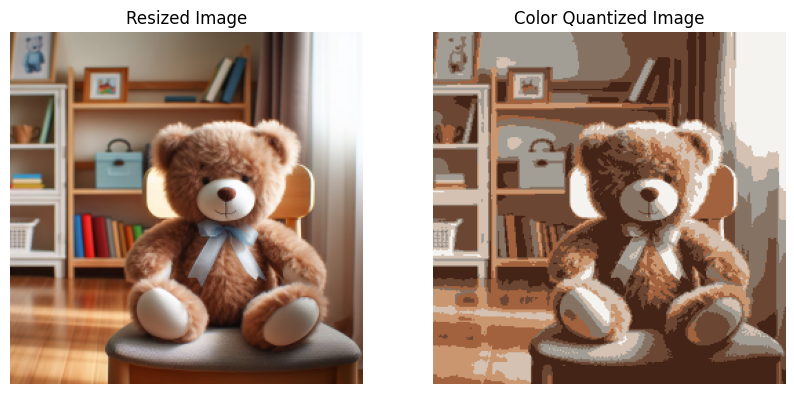

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load the image using OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Resize the image to a fixed resolution
fixed_size = (256, 256)  # Set your preferred size
image_resized = cv2.resize(image, fixed_size, interpolation=cv2.INTER_AREA)

# Apply color quantization using K-means clustering
def color_quantization(image, k=8):
    """Reduce the number of colors in the image using K-means clustering."""
    pixels = image.reshape((-1, 3))  # Reshape to (num_pixels, 3)
    pixels = np.float32(pixels)  # Convert to float

    # Apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, palette = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    quantized = palette[labels.flatten()].reshape(image.shape)  # Reconstruct image
    return np.uint8(quantized)

# Reduce colors to 8 clusters
image_quantized = color_quantization(image_resized, k=8)

# Display original and processed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_resized)
ax[0].set_title("Resized Image")
ax[0].axis("off")

ax[1].imshow(image_quantized)
ax[1].set_title("Color Quantized Image")
ax[1].axis("off")

plt.show()

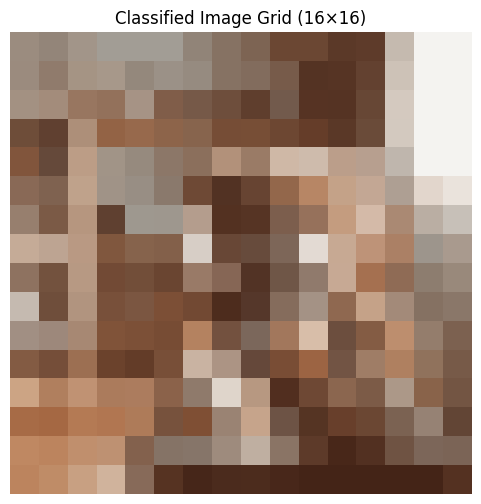

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set grid size (e.g., 16×16)
grid_size = 16
height, width, _ = image_quantized.shape
cell_h, cell_w = height // grid_size, width // grid_size

# Create a grid and classify cells
grid_colors = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)

for i in range(grid_size):
    for j in range(grid_size):
        # Extract each grid cell
        y1, y2 = i * cell_h, (i + 1) * cell_h
        x1, x2 = j * cell_w, (j + 1) * cell_w
        cell = image_quantized[y1:y2, x1:x2]

        # Compute average color in the cell
        avg_color = np.mean(cell, axis=(0, 1))

        # Assign the cell to a color category (rounding to the nearest color)
        grid_colors[i, j] = np.round(avg_color)

# Display the classified grid
plt.figure(figsize=(6, 6))
plt.imshow(grid_colors)
plt.title(f"Classified Image Grid ({grid_size}×{grid_size})")
plt.axis("off")
plt.show()

In [ ]:
import kagglehub

# Download the latest version of the cat dataset
path = kagglehub.dataset_download("crawford/cat-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2


Total cat images found: 9997


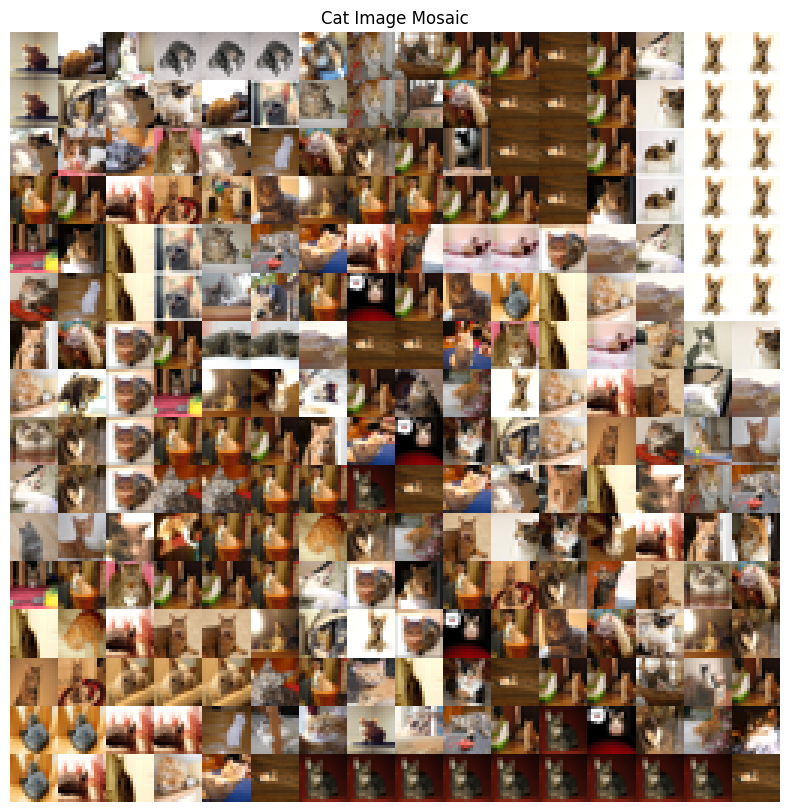

In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Set the correct directory path
cat_images_dir = "/root/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2"

# Load all cat images from CAT_00 to CAT_06
cat_images_paths = glob(os.path.join(cat_images_dir, "CAT_*", "*.jpg"))  # Scan all "CAT_XX" folders

# Ensure we have enough images
print(f"Total cat images found: {len(cat_images_paths)}")

# Resize cat images to match grid cell size
tile_size = (height // grid_size, width // grid_size)  # Ensure this matches your image grid

cat_tiles = []
for img_path in cat_images_paths[:500]:  # Load first 500 images to avoid memory issues
    try:
        cat_img = Image.open(img_path).convert("RGB")
        cat_img = cat_img.resize(tile_size)
        cat_tiles.append(np.array(cat_img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Compute average colors of cat tiles
cat_avg_colors = np.array([np.mean(tile, axis=(0,1)) for tile in cat_tiles])

# Create the final mosaic
mosaic_image = np.zeros((height, width, 3), dtype=np.uint8)

for i in range(grid_size):
    for j in range(grid_size):
        # Extract the grid cell color
        cell_color = grid_colors[i, j]

        # Find the closest matching cat image
        distances = cdist([cell_color], cat_avg_colors, metric='euclidean')
        best_match_idx = np.argmin(distances)
        best_cat_tile = cat_tiles[best_match_idx]

        # Place the cat tile in the final image
        y1, y2 = i * tile_size[0], (i + 1) * tile_size[0]
        x1, x2 = j * tile_size[1], (j + 1) * tile_size[1]
        mosaic_image[y1:y2, x1:x2] = best_cat_tile

# Show the final mosaic
plt.figure(figsize=(10, 10))
plt.imshow(mosaic_image)
plt.title("Cat Image Mosaic")
plt.axis("off")
plt.show()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
import os
from glob import glob
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity as ssim

# Load cat images for mosaic tiles
cat_images_dir = "/root/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2"
cat_images_paths = glob(os.path.join(cat_images_dir, "CAT_*", "*.jpg"))

# Resize and store cat images
tile_size = (32, 32)  # Default tile size
cat_tiles = []

for img_path in cat_images_paths[:500]:  # Limit to 500 images for performance
    try:
        cat_img = Image.open(img_path).convert("RGB")
        cat_img = cat_img.resize(tile_size)
        cat_tiles.append(np.array(cat_img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Compute average colors of cat tiles
cat_avg_colors = np.array([np.mean(tile, axis=(0, 1)) for tile in cat_tiles])

def compute_metrics(original, mosaic):
    """Computes MSE and SSIM between the original and mosaic images."""
    original = np.array(original.resize(mosaic.size))
    mosaic = np.array(mosaic)

    mse_value = np.mean((original - mosaic) ** 2)
    ssim_value = ssim(original, mosaic, channel_axis=-1, data_range=255)

    return mse_value, ssim_value

def generate_mosaic(input_image, grid_size):
    """Function to create the cat image mosaic."""
    input_image = input_image.convert("RGB")
    width, height = input_image.size
    grid_width, grid_height = width // grid_size, height // grid_size

    input_array = np.array(input_image)
    mosaic_image = np.zeros_like(input_array)

    for i in range(grid_size):
        for j in range(grid_size):
            y1, y2 = i * grid_height, (i + 1) * grid_height
            x1, x2 = j * grid_width, (j + 1) * grid_width
            cell_color = np.mean(input_array[y1:y2, x1:x2], axis=(0, 1))

            # Find best matching cat tile
            distances = cdist([cell_color], cat_avg_colors, metric='euclidean')
            best_match_idx = np.argmin(distances)

            if len(cat_tiles) > best_match_idx:
                best_cat_tile = cat_tiles[best_match_idx]
                best_cat_tile_resized = np.array(Image.fromarray(best_cat_tile).resize((grid_width, grid_height)))

                mosaic_image[y1:y2, x1:x2] = best_cat_tile_resized

    mosaic_pil = Image.fromarray(mosaic_image)
    mse, ssim_score = compute_metrics(input_image, mosaic_pil)

    return mosaic_pil, f"{mse:.2f}", f"{ssim_score:.4f}"

# **Define sample images for testing**
sample_images = ["sample_images/test1.jpg", "sample_images/test2.jpg", "sample_images/test3.jpg"]

# Define Gradio Interface with Examples
with gr.Blocks() as demo:
    gr.Markdown("## 🐱 Cat Image Mosaic Generator 🎨")

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload an Image")
        output_image = gr.Image(type="pil", label="Mosaic Output")

    grid_size_slider = gr.Slider(8, 128, step=8, label="Grid Size", value=16)

    generate_button = gr.Button("Generate Mosaic")

    mse_output = gr.Textbox(label="MSE Score")
    ssim_output = gr.Textbox(label="SSIM Score")

    # Add sample images as clickable examples
    gr.Examples(
        examples=sample_images,
        inputs=[input_image]
    )

    generate_button.click(generate_mosaic,
                          inputs=[input_image, grid_size_slider],
                          outputs=[output_image, mse_output, ssim_output])

# Launch the Gradio app in Colab
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50bfb75b7b6d7e4fa2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!git clone https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator

Cloning into 'Interactive_Image_Mosaic_Generator'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.29 KiB | 662.00 KiB/s, done.


In [ ]:
%cd Interactive_Image_Mosaic_Generator

/content/Interactive_Image_Mosaic_Generator


In [ ]:
%%writefile app.py
import gradio as gr
import numpy as np
from PIL import Image
import os
from glob import glob
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity as ssim

# Load cat images for mosaic tiles
cat_images_dir = "/root/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2"
cat_images_paths = glob(os.path.join(cat_images_dir, "CAT_*", "*.jpg"))

# Resize and store cat images
tile_size = (32, 32)  # Default tile size
cat_tiles = []

for img_path in cat_images_paths[:500]:  # Limit to 500 images for performance
    try:
        cat_img = Image.open(img_path).convert("RGB")
        cat_img = cat_img.resize(tile_size)
        cat_tiles.append(np.array(cat_img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Compute average colors of cat tiles
cat_avg_colors = np.array([np.mean(tile, axis=(0, 1)) for tile in cat_tiles])

def compute_metrics(original, mosaic):
    """Computes MSE and SSIM between the original and mosaic images."""
    original = np.array(original.resize(mosaic.size))
    mosaic = np.array(mosaic)

    mse_value = np.mean((original - mosaic) ** 2)
    ssim_value = ssim(original, mosaic, channel_axis=-1, data_range=255)

    return mse_value, ssim_value

def generate_mosaic(input_image, grid_size):
    """Function to create the cat image mosaic."""
    input_image = input_image.convert("RGB")
    width, height = input_image.size
    grid_width, grid_height = width // grid_size, height // grid_size

    input_array = np.array(input_image)
    mosaic_image = np.zeros_like(input_array)

    for i in range(grid_size):
        for j in range(grid_size):
            y1, y2 = i * grid_height, (i + 1) * grid_height
            x1, x2 = j * grid_width, (j + 1) * grid_width
            cell_color = np.mean(input_array[y1:y2, x1:x2], axis=(0, 1))

            # Find best matching cat tile
            distances = cdist([cell_color], cat_avg_colors, metric='euclidean')
            best_match_idx = np.argmin(distances)

            if len(cat_tiles) > best_match_idx:
                best_cat_tile = cat_tiles[best_match_idx]
                best_cat_tile_resized = np.array(Image.fromarray(best_cat_tile).resize((grid_width, grid_height)))

                mosaic_image[y1:y2, x1:x2] = best_cat_tile_resized

    mosaic_pil = Image.fromarray(mosaic_image)
    mse, ssim_score = compute_metrics(input_image, mosaic_pil)

    return mosaic_pil, f"{mse:.2f}", f"{ssim_score:.4f}"

# **Define sample images for testing**
sample_images = ["sample_images/test1.jpg", "sample_images/test2.jpg", "sample_images/test3.jpg"]

# Define Gradio Interface with Examples
with gr.Blocks() as demo:
    gr.Markdown("## 🐱 Cat Image Mosaic Generator 🎨")

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload an Image")
        output_image = gr.Image(type="pil", label="Mosaic Output")

    grid_size_slider = gr.Slider(8, 128, step=8, label="Grid Size", value=16)

    generate_button = gr.Button("Generate Mosaic")

    mse_output = gr.Textbox(label="MSE Score")
    ssim_output = gr.Textbox(label="SSIM Score")

    # Add sample images as clickable examples
    gr.Examples(
        examples=sample_images,
        inputs=[input_image]
    )

    generate_button.click(generate_mosaic,
                          inputs=[input_image, grid_size_slider],
                          outputs=[output_image, mse_output, ssim_output])

# Launch the Gradio app
demo.launch()

Writing app.py


In [ ]:
%%writefile requirements.txt
opencv-python
numpy
matplotlib
gradio
Pillow
scipy
scikit-image

Writing requirements.txt


In [ ]:
%%writefile packages.txt
libgl1-mesa-glx

Writing packages.txt


In [ ]:
!git add app.py requirements.txt packages.txt
!git commit -m "Added application and dependencies"
!git push

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@66e762e5e185.(none)')
fatal: could not read Username for 'https://huggingface.co': No such device or address


In [ ]:
!git config --global user.email "dasawat.s@northeastern.edu"
!git config --global user.name "dsnahil"

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!git clone https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
%cd Interactive_Image_Mosaic_Generator

Cloning into 'Interactive_Image_Mosaic_Generator'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.29 KiB | 1.29 MiB/s, done.
/content/Interactive_Image_Mosaic_Generator/Interactive_Image_Mosaic_Generator


In [ ]:
!git add app.py requirements.txt packages.txt
!git commit -m "Added application and dependencies"
!git push

fatal: pathspec 'app.py' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [ ]:
!pwd
!ls

/content/Interactive_Image_Mosaic_Generator/Interactive_Image_Mosaic_Generator
README.md


In [ ]:
%%writefile app.py
# Your Gradio code here (copy-paste your full script again)


Writing app.py


In [ ]:
%cd /content/Interactive_Image_Mosaic_Generator

/content/Interactive_Image_Mosaic_Generator


In [ ]:
!ls

app.py	Interactive_Image_Mosaic_Generator  packages.txt  README.md  requirements.txt


In [ ]:
!git add app.py requirements.txt packages.txt
!git commit -m "Added application and dependencies"
!git push


[main fda0dae] Added application and dependencies
 3 files changed, 105 insertions(+)
 create mode 100644 app.py
 create mode 100644 packages.txt
 create mode 100644 requirements.txt
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 1.83 KiB | 1.83 MiB/s, done.
Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
   834ec7c..fda0dae  main -> main


In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up Kaggle authentication using environment variables
os.environ["KAGGLE_USERNAME"] = "snahildasawat"
os.environ["KAGGLE_KEY"] = "cad74a31b40b76850a7aaf89fb354fbe"

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Download dataset
dataset_path = "/content/cat-dataset"
os.makedirs(dataset_path, exist_ok=True)

if not os.path.exists(f"{dataset_path}/CAT_00"):
    print("Downloading dataset from Kaggle...")
    api.dataset_download_files("crawford/cat-dataset", path=dataset_path, unzip=True)
else:
    print("Dataset already exists. Skipping download.")

print("Kaggle dataset is ready!")


Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset
Kaggle dataset is ready!


In [ ]:
!ls -la /content/Interactive_Image_Mosaic_Generator/


total 48
drwxr-xr-x 6 root root 4096 Feb  6 09:08 .
drwxr-xr-x 1 root root 4096 Feb  6 08:46 ..
-rw-r--r-- 1 root root 3482 Feb  6 08:20 app.py
drwxr-xr-x 8 root root 4096 Feb  6 08:53 .git
-rw-r--r-- 1 root root 1519 Feb  6 08:19 .gitattributes
drwxr-xr-x 5 root root 4096 Feb  6 09:13 Interactive_Image_Mosaic_Generator
drwxr-xr-x 2 root root 4096 Feb  6 09:08 .ipynb_checkpoints
-rw-r--r-- 1 root root   69 Feb  6 08:50 kaggle.json
-rw-r--r-- 1 root root   16 Feb  6 08:20 packages.txt
-rw-r--r-- 1 root root  253 Feb  6 08:19 README.md
-rw-r--r-- 1 root root   64 Feb  6 08:20 requirements.txt
drwxr-xr-x 2 root root 4096 Feb  6 09:09 sample_images


In [ ]:
!ls -la /content/Interactive_Image_Mosaic_Generator/Interactive_Image_Mosaic_Generator/


total 44
drwxr-xr-x 5 root root 4096 Feb  6 09:13 .
drwxr-xr-x 6 root root 4096 Feb  6 09:08 ..
-rw-r--r-- 1 root root 3583 Feb  6 09:13 app.py
drwxr-xr-x 8 root root 4096 Feb  6 09:13 .git
-rw-r--r-- 1 root root 1519 Feb  6 08:25 .gitattributes
drwxr-xr-x 2 root root 4096 Feb  6 09:13 Interactive_Image_Mosaic_Generator
-rw-r--r-- 1 root root   69 Feb  6 09:13 kaggle.json
-rw-r--r-- 1 root root   16 Feb  6 09:13 packages.txt
-rw-r--r-- 1 root root  253 Feb  6 08:25 README.md
-rw-r--r-- 1 root root   64 Feb  6 09:13 requirements.txt
drwxr-xr-x 2 root root 4096 Feb  6 09:05 sample_images


In [ ]:
!git push


Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.14 MiB | 3.65 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
   ec5d5ab..77dbf30  main -> main


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
import os
from glob import glob
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity as ssim
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Ensure Kaggle credentials are set from environment variables
os.environ["KAGGLE_USERNAME"] = "snahildasawat"
os.environ["KAGGLE_KEY"] = "cad74a31b40b76850a7aaf89fb354fbe"

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Define dataset path inside the working directory
dataset_path = "cat-dataset"

# Check if the dataset is already downloaded
if not os.path.exists(dataset_path):
    print("Downloading dataset from Kaggle...")
    api.dataset_download_files("crawford/cat-dataset", path=dataset_path, unzip=True)
else:
    print("Dataset already exists. Skipping download.")

# ✅ Use the correct dataset path
cat_images_dir = dataset_path

# ✅ Use a proper `glob` pattern to find all images
cat_images_paths = glob(os.path.join(cat_images_dir, "**", "*.jpg"), recursive=True)

# Resize and store cat images
tile_size = (32, 32)  # Default tile size
cat_tiles = []

for img_path in cat_images_paths[:500]:  # Limit to 500 images for performance
    try:
        cat_img = Image.open(img_path).convert("RGB")
        cat_img = cat_img.resize(tile_size)
        cat_tiles.append(np.array(cat_img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Compute average colors of cat tiles
cat_avg_colors = np.array([np.mean(tile, axis=(0, 1)) for tile in cat_tiles])

def compute_metrics(original, mosaic):
    """Computes MSE and SSIM between the original and mosaic images."""
    original = np.array(original.resize(mosaic.size))
    mosaic = np.array(mosaic)

    mse_value = np.mean((original - mosaic) ** 2)
    ssim_value = ssim(original, mosaic, channel_axis=-1, data_range=255)

    return mse_value, ssim_value

def generate_mosaic(input_image, grid_size):
    """Function to create the cat image mosaic."""
    input_image = input_image.convert("RGB")
    width, height = input_image.size
    grid_width, grid_height = width // grid_size, height // grid_size

    input_array = np.array(input_image)
    mosaic_image = np.zeros_like(input_array)

    for i in range(grid_size):
        for j in range(grid_size):
            y1, y2 = i * grid_height, (i + 1) * grid_height
            x1, x2 = j * grid_width, (j + 1) * grid_width
            cell_color = np.mean(input_array[y1:y2, x1:x2], axis=(0, 1))

            # Find best matching cat tile
            distances = cdist([cell_color], cat_avg_colors, metric='euclidean')
            best_match_idx = np.argmin(distances)

            if len(cat_tiles) > best_match_idx:
                best_cat_tile = cat_tiles[best_match_idx]
                best_cat_tile_resized = np.array(Image.fromarray(best_cat_tile).resize((grid_width, grid_height)))

                mosaic_image[y1:y2, x1:x2] = best_cat_tile_resized

    mosaic_pil = Image.fromarray(mosaic_image)
    mse, ssim_score = compute_metrics(input_image, mosaic_pil)

    return mosaic_pil, f"{mse:.2f}", f"{ssim_score:.4f}"

# **Define sample images for testing**
sample_images = ["sample_images/test1.jpg", "sample_images/test2.jpg", "sample_images/test3.jpg"]

# Define Gradio Interface with Examples
with gr.Blocks() as demo:
    gr.Markdown("## 🐱 Cat Image Mosaic Generator 🎨")

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload an Image")
        output_image = gr.Image(type="pil", label="Mosaic Output")

    grid_size_slider = gr.Slider(8, 128, step=8, label="Grid Size", value=16)

    generate_button = gr.Button("Generate Mosaic")

    mse_output = gr.Textbox(label="MSE Score")
    ssim_output = gr.Textbox(label="SSIM Score")

    # Add sample images as clickable examples
    gr.Examples(
        examples=sample_images,
        inputs=[input_image]
    )

    generate_button.click(generate_mosaic,
                          inputs=[input_image, grid_size_slider],
                          outputs=[output_image, mse_output, ssim_output])

# Launch the Gradio app
demo.launch()


Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a6f1646aa76d55e46f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!git pull --rebase origin main


remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 2.32 KiB | 339.00 KiB/s, done.
From https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
 * branch            main       -> FETCH_HEAD
   77dbf30..029a3d4  main       -> origin/main
Updating 77dbf30..029a3d4
Fast-forward
 app.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!git add app.py
!git commit -m "Fixed dataset path in app.py"
!git push


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [ ]:
!git add app.py
!git commit -m "Fixed dataset handling and added auto-download"
!git push


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
To https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [ ]:
!git fetch origin


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.42 KiB | 1.42 MiB/s, done.
From https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
   a6c8fb0..7c69db1  main       -> origin/main
Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
and remove .git/gc.log
Automatic cleanup will not be performed until the file is removed.




In [ ]:
!git push origin main


Enumerating objects: 42, done.
Counting objects: 100% (42/42), done.
Delta compression using up to 2 threads
Compressing objects: 100% (38/38), done.
Writing objects: 100% (42/42), done.
Total 42 (delta 15), reused 18 (delta 0), pack-reused 0


In [ ]:
!git fetch origin


In [ ]:
!git push origin main


Everything up-to-date


In [ ]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
!git add requirements.txt
!git commit -m "Added Kaggle dependency to requirements.txt"
!git push


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
To https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [ ]:
!git pull origin main --rebase


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 973 bytes | 973.00 KiB/s, done.
From https://huggingface.co/spaces/dsnahil/Interactive_Image_Mosaic_Generator
 * branch            main       -> FETCH_HEAD
   7c69db1..f7a0509  main       -> origin/main
Updating 7c69db1..f7a0509
Fast-forward
 requirements.txt | 1 +
 1 file changed, 1 insertion(+)


In [ ]:
!git push origin main


Everything up-to-date
